# Design Patterns: learn from others' experience

Having learned programming constructs, such as for loops and if/else statements, main library functions such as _math_ and _random_ and a few tools such as _docker_ and _mypy_, have you learned everything a software engineer, programmer or a data scientist needs? Are you on your own now?

No!

Computer programming, being a mature profession means we must do a good job of learning the techniques others have developed. In computer programming, this is called the study of design patterns.

#### Finding common solutions to common problems (not innovation)

In 1977, Christopher Alexander wrote "A Pattern Language." 

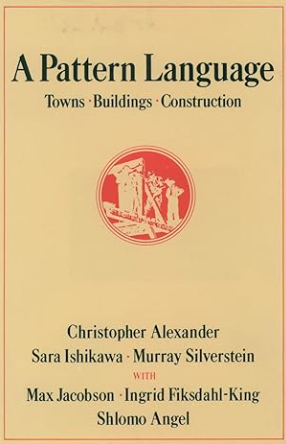

In this book, he explored common patterns - progblems which occur often, and solutions for them:

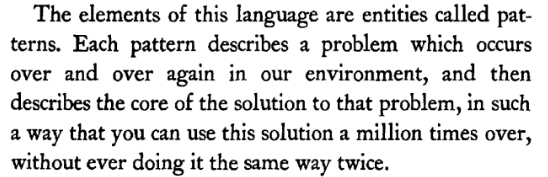

#### The Gand of Four apply these lessons to software

1n 1995, Gamma, Helm, Johnson and Vlissides published "Design Patterns"

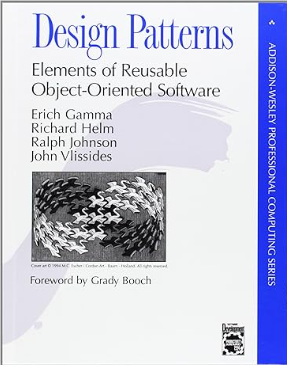

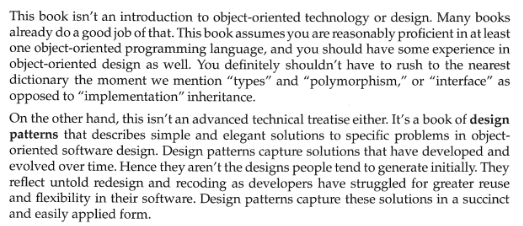

The GoF book presents the following patterns:

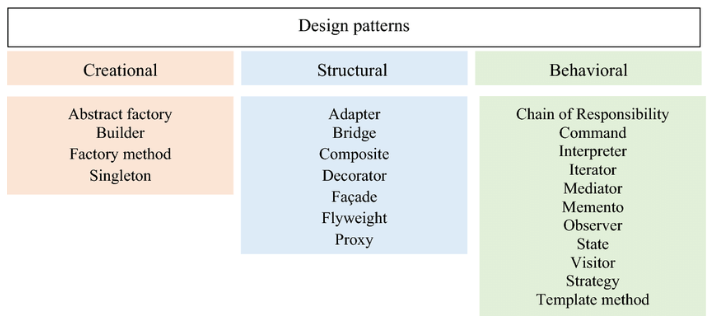

Source: https://www.researchgate.net/figure/Design-patterns-categories-GoF_fig31_340792618

There is no central repository of patterns, although many book and websites provide their own takes on a catalog of patterns. Interestingly, patterns are often described in a language neutral way. The same set of patterns can be implemented in different langauges. 

This look like a very nice website, describing various patterns via text, code and visual examples: https://refactoring.guru/

### The strategy pattern
Pick different logic during runtime

The strategy pattern allows users to pick a specific "strategy" while the program is running, rather than at the time when the program was being written by the developer. This is also very close to how you can implement _plugins_ in your software.

For data scientist, a good example might be to pick different machine learing models. A user may decide to pick _svm_ or _logistic regression_ for a dataset during runtime:

Try svm:

```bash
python build-classifier.py --model svm --csv inputfile.csv --target-col age
```

Now try logistic regression:

```bash
python build-classifier.py --model logreg --csv inputfile.csv --target-col age
```



Notice that we only changed the `--model` parameter. This is because all classification models share the same interface. We can swap out one implementation for another, without changing the whole logic of classification

This code available under programs/svm_or_logreg_strategy.py

```python
import argparse
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

def build_classifier(args):
    # Read CSV file
    df = pd.read_csv(args.csv)
    
    # Ignore specified columns
    if args.ignore_cols:
        df = df.drop(columns=args.ignore_cols, errors='ignore')
    
    # Convert categorical columns to one-hot encoding
    categorical_cols = df.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        df = pd.get_dummies(df, columns=categorical_cols)
    
    # Encode target column
    label_encoder = LabelEncoder()
    df[args.target_col] = label_encoder.fit_transform(df[args.target_col])
    
    # Split data into features and target
    X = df.drop(columns=[args.target_col])
    y = df[args.target_col]
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Choose classifier model
    if args.model == "svm":  # <== We are able to pick the right model or 'strategy' at runtime
        clf = SVC()
    elif args.model == "logreg":
        clf = LogisticRegression()
    
    # Train classifier
    clf.fit(X_train, y_train) # <== This code is the same, svm or logreg
    
    # Predict on test set
    y_pred = clf.predict(X_test) # <== This code is the same, svm or logreg
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    return cm

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Build a classifier")
    parser.add_argument("--model", choices=["svm", "logreg"], required=True, help="Type of classifier model")
    parser.add_argument("--csv", required=True, help="CSV input file")
    parser.add_argument("--target-col", required=True, help="Target column name")
    parser.add_argument("--ignore-cols", nargs='+', default=[], help="Columns to ignore")
    
    args = parser.parse_args()
    confusion_matrix = build_classifier(args)
    print("Confusion Matrix:")
    print(confusion_matrix)
```

See note below about ChatGPT

#### Adding plugins to you program

Instead of providing the strings 'svm' or 'logreg' and having Python look up the coresponding class, what if you provide the full classpath? Python could read the class, load it and execute the `.fit` and `.predict` functions. Essentially, you have created a 'plugin' system for your program!

### The pipeline pattern

In an earlier lecture (python basics: 240-functions_lambda_and_higher_order), we saw a way to combine a number of procedures into a single pipeline:

In [ ]:
names = ["Homer\n", "lisa ", "mArge", "Mr. Burns", "Barney", "Mrs, Krabappel"]

transformation_pipe = [
    lambda x: x.lower() # make all characters lower case
    , lambda x: x.strip() # remove useless characters
    , lambda x: x.replace(',','.') # fix typos
    , lambda x: x.capitalize() # don't lower case _everything_
]

transformed_names = list()

for name in names: # go through the names
    cleaned_name = name
    
    for t in transformation_pipe: # go through the transformations for each name
        cleaned_name = t(cleaned_name)
        
    transformed_names.append(cleaned_name)
    
transformed_names

Notice that this code is not specific to this problem. This shows how to build a generic pipeline, that can be used in any number of situation. 

A more detailed example is the `Pipeline` object that comes with the scikit-learn library:

```python
from sklearn import pipeline

X_train, X_test, y_train, y_test = train_test_split(
    titanic_onlynum_df.drop(['survived'], axis=1)
    #titanic_onlynum_noempty_df.drop(['survived'], axis=1)
    , titanic_onlynum_df.survived
    #, titanic_onlynum_noempty_df.survived
    , random_state=1)

pipe = pipeline.make_pipeline(
    # Transformers
    impute.SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
    ,preprocessing.StandardScaler()
    ,preprocessing.PowerTransformer()
    ,svm.SVC(C=1.0, kernel='rbf') # <== Classifier
)


pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)
```

Notice how this pipeline is robust enough that we can operate on it directly. Even the for loop from earlier has been abstracted out. In fact, this pipeline of transformations can be operated on as a simple transformation!

### The visitor pattern
The visitor pattern is useful in senarios where you are working with related (but not identical) objects with related (but not identical logic). Unlike the strategy pattern, which takes advantage of various objects having the same interface, the visitor pattern takes advantage of related objects which are composed of each other. Sounds confusing but the idea becomes easy with an example: calculator!

Think back to the notebook on data structures (all of python basics, 270-data_structures). We had a binary tree which represented an arithmetic expression and we wrote code to evaluate that expression:

In [ ]:
class BinaryTree():
    def __init__(self, value, left_child, right_child):
        self.value = value
        self.left_child = left_child
        self.right_child = right_child
        
    def __repr__(self): # (calling the str() function automatically calls the __repr__ function)
        
        left_repr = str(self.left_child) if self.left_child is not None else ''
        right_repr = str(self.right_child) if self.right_child is not None else ''

        output = list()
        output.append('(')
        output.append(self.value) 
        output.append(left_repr)
        output.append(right_repr)
        output.append(')')

        return ' '.join(output)
            
    
    def __len__(self):
        left, right = 0, 0
        
        if self.left_child is not None:
            left = len(self.left_child)
        if self.right_child is not None:
            right = len(self.right_child)
        return 1 + left + right

In [ ]:
# (12 + x) / 1
math_expr = BinaryTree('/', 
                  BinaryTree('+', 
                             BinaryTree('12', None, None), 
                             BinaryTree('x', None, None)), 
                  BinaryTree('1', None, None)
                 )

In [ ]:
#Notice that we are skipping loads of error checking here

def eval_expr(bintree, x):
    operator = bintree.value
    if operator.isnumeric():
        return int(operator)
    elif operator == '+':
        left_operand = eval_expr(bintree.left_child, x)
        right_operand = eval_expr(bintree.right_child, x)
        return left_operand + right_operand
    elif operator == '-':
        left_operand = eval_expr(bintree.left_child, x)
        right_operand = eval_expr(bintree.right_child, x)
        return left_operand - right_operand
    elif operator == '*':
        left_operand = eval_expr(bintree.left_child, x)
        right_operand = eval_expr(bintree.right_child, x)
        return left_operand * right_operand
    elif operator == '/':
        left_operand = eval_expr(bintree.left_child, x)
        right_operand = eval_expr(bintree.right_child, x)
        return left_operand / right_operand
    elif operator == 'x':
        return x
    else:
        return f"ERROR: Operator '{operator}' not found" # Should raise an exception

In [ ]:
variable_value = 5
eval_expr(math_expr, variable_value)

To create a proper visitor pattern, we would have to create a new object for each expression type: add, subtract, multiply, etc. Seee visitor pattern docs for more detail.

## Patterns Python doesn't need

There are some common patterns which don't benefit Python programmers, as much as other languages. This is because Python already provides some of the functionality as a language feature or a library

### The builder pattern
The build pattern helps design an API which is difficult to use incorrectly. For example, if you are building a new, high level, machine learning library, it might look like this:

```python
model = ClassifierModel(ResNet50(), AdamOpitmizer(), CrossEntropyCostFunction())
model.fit(...)
```

In this library you had to list the architecture, the optimizer and the cost function. What if you could provide good defaults, so the end-user wouldn't have to think about such details? Secondly, given the signature of the function `ClassifierModel(arg1, arg2, arg3)`, how can you disambiguate between the different types of arguments?

If we weren't using Python, this may indeed be a problem. Perhaps you could provide a more detailed constructor which works like this:

```python
model = ClassifierModelBuilder().addArchitecture(ResNet50()).addOptimizer(AdamOptimizer()).build()
```
The functions `addModel` and `addOptimizer` could be written, roughly, as such:

```python
class ClassifierModelBuilder():
    def __init__():
        pass
        
    def addArchitecture(self, architecture):
        self.architecture = architecture
        return self
        
    def addOptimizer(wself, optimizer):
        self.optimizer = optimizer
        return self

    def addCostFunction(self, cost_function):
        self.cost_function = cost_function
        return self
        
    def build():
        if not self.architecture: self.architecture = DefaultResnet100()
        if not self.optimizer: self.optimizer = AdamOptimizer()
        if not self.cost_function: self.cost_function = CrossEntropyCostFunction()
        
        return ClassifierModel(self.architecture, self.optimizer, self.cost_function)
        
```

However, in Python, we can just use named parameters

```python
def create_model(architecture=DefaultResnet100(), optimizer=AdamOptimizer(), cost_function=CrossEntropyCostFunction()):
    return ClassifierModel(architecture, optimizer, cost_function)
```

You can now call this function with any or no parameters:

```python
model_a = create_model()
model_b = create_model(architecture=Resnet50())
model_c = create_model(optimizer=AdamOptimizer())
```

#### Decorator and Iterator patterns
Python provides built-in syntax for the decorator pattern via:

```python
@decorator
def function(arg1, arg2):
    ...
```

The iterator pattern is avilable in Python via generators.

### Other patterns
The idea of "deisgn patterns" is now extended beyond the original GoF patterns and closer to the meaning in the book on towns and cities: common practices, distilled and cataloged. 

Architectural patterns have become popular in the lats 10-15 years via books such as this:

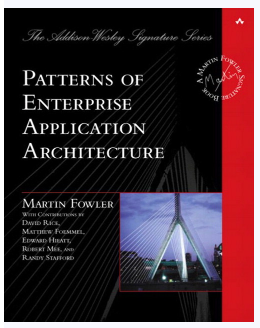

Which contains these patterns:

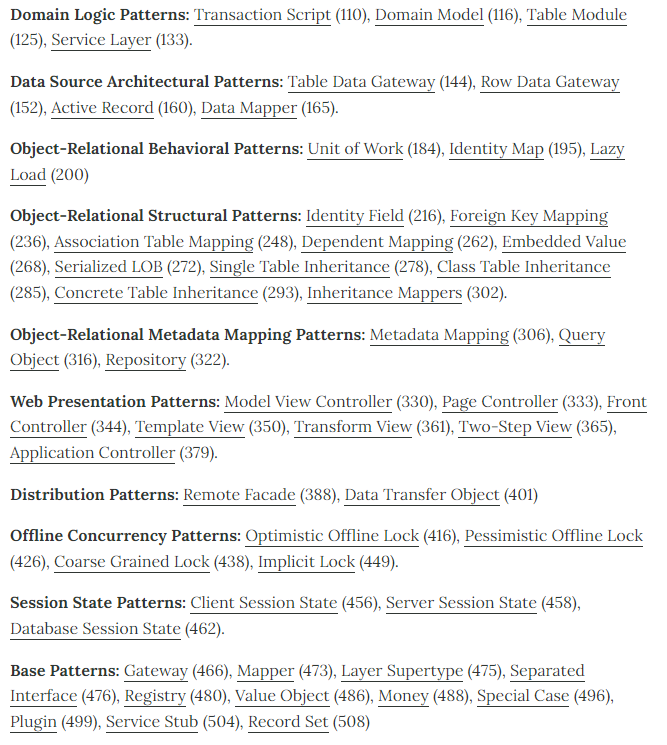

Source: https://martinfowler.com/eaaCatalog/

Recently, there have been books published on patterns within the machine learning space:

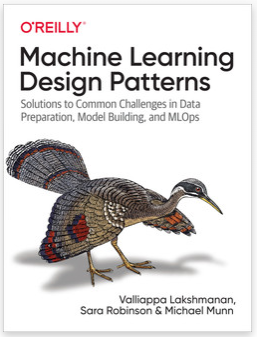

https://www.oreilly.com/library/view/machine-learning-design/9781098115777/

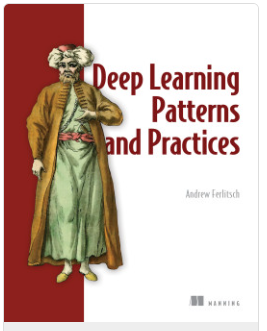

https://www.manning.com/books/deep-learning-patterns-and-practices

#### ChatGPT ...
The svm vs logistic regression code was developed, almost exclusively via ChatGPT! 
I started with the initial request:

```
write a python program which is able to execute code like these examples:

'''python
python build-classifier.py --model svm --csv inputfile.csv --target-col age
python build-classifier.py --model logreg --csv inputfile.csv --target-col age
'''
```

This generated a few lines of code which parsed the arguments and not much else. I then followed up with:

```
actually implement the logic which reads csv files using pandas and runs scikit-learn's svm or logistic regression model and returns the confusion matrix
```

This presented me with 90% fo the code seen above. However, running the code on actual files was giving me errors because I hadn't taken care of categorical variables. I asked for more refinement:

```
Please add a parameter to ignore columns and add code to convert categorical columns
```

Other than 3 lines of comment I added about code being similar between svm and logreg, the code above was completely generated by ChatGPT. It isn't free of bugs, nor has it pre-processed the data as a data scientist would, but the result is shockingly coherent just the same!